In [1]:
import numpy as np
from quasildr.structdr import Scms

T=np.loadtxt('./data/other/inference_simulation.T.txt')

#Ground truth is the smoothed density ridge Ttrue
s = Scms(T, bw=np.sqrt(0.05**2+0.15**2), min_radius = 0)
Ttrue, _ = s.scms(T, n_jobs = 30, stepsize=1, n_iterations= 20,ridge_dimensionality=1)


In [2]:
## Note: this step is slow, you may also skip this and load the precomputed simulation instead

#generated simulated data
simdatas = []
for i in range(100):
    simdatas.append( T  + np.random.randn(*T.shape)*0.05)

#estimate trajectories from simulated data
simdata_Ts = []
for simdata in simdatas:
    s = Scms(simdata, bw=0.15, min_radius = 0)
    simdata_T, _ = s.scms(T, n_jobs = 30, stepsize=1, n_iterations= 20,ridge_dimensionality=1)
    simdata_Ts.append(simdata_T)

#inference by bootstrap for estimated trajectories
simdatas_bootdata_Ts=[]
for simdata in simdatas:
    bootdata_Ts=[]
    bootdatainds = []
    for i in range(20):
        bootdataind = np.random.randint(0, T.shape[0],T.shape[0])
        bootdatainds.append(bootdataind)
        bootdata = simdata[bootdataind,:]
        bootdata = simdata + np.random.randn(*T.shape)*0.05
        s = Scms(bootdata, bw=0.15, min_radius = 0)
        bootdata_T, _ = s.scms(T, n_jobs = 30, stepsize=1, n_iterations= 20,ridge_dimensionality=1)
        bootdata_Ts.append(bootdata_T)
    simdatas_bootdata_Ts.append(bootdata_Ts)
    

In [3]:
#load precomputed simulation results
import joblib
simdatas_bootdata_Ts = joblib.load('./data/other/simdatas_bootdata_Ts.pkl')
simdata_Ts = joblib.load('./data/other/simdata_Ts.pkl')
simdatas = joblib.load('./data/other/simdatas.pkl')

In [4]:
#we compute the corresponding confidence sets coverage probability of ground truth density ridge
from sklearn.neighbors import NearestNeighbors

cov_probs = []
for i in range(100):
    cov_probs.append(np.mean(NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Ttrue).kneighbors(simdata_Ts[i])[0]
                       < np.hstack([ NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(simdata_Ts[i]).kneighbors(a)[0] for a in simdatas_bootdata_Ts[i]]),axis=1))


((array([3.80578185e-07, 9.23790514e-07, 1.47284877e-06, ...,
         9.99998527e-01, 9.99999076e-01, 9.99999619e-01]),
  array([0., 0., 0., ..., 1., 1., 1.])),
 (1.0393334020566027, -0.004385830221734555, 0.9986749945769635))

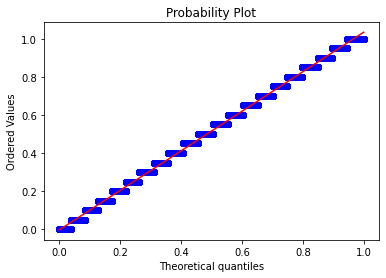

In [5]:
#verify that the overall distribution is uniform 
from scipy.stats import probplot, uniform
from matplotlib import pyplot as plt
probplot(np.vstack(cov_probs).flatten(), dist=uniform,  plot=plt)

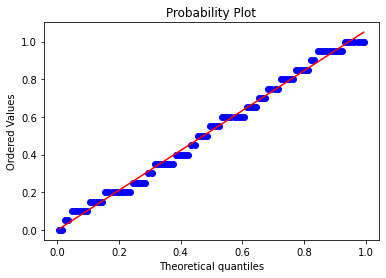

In [7]:
#the distribution for any particular position is also uniform
probplot(np.vstack(cov_probs)[:,100], dist=uniform,  plot=plt)
plt.show()